# Open Food Facts Course Project - Cleaning, manipulating and visualizing

First of all, let's import usefull libraries for the project and make matplolib displaying graphs inline the Notebook.

In [59]:
from os import path # For filepath manipulation
import pandas as pd
import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn

Next step will be to load the Open Food Facts CSV file, which in fact is a TSV file (Cells are separated with tabs).
Loading this file will take a consequent amount of time, as the file is 1Gb big. First thing to do will be to perform some cleanup and removal of useless data, and save the result as a new CSV file.

This new CSV file will be used as datasource in this Notebook using the first **MAX_ENTRY_TO_LOAD** rows while coding.

**Don't forget to set MAX_ENTRY_TO_LOAD = None when coding is finished.** Otherwise, only a subset of the data will be processed.

* Note that this Notebook checks if the cleaned Datafile exists and create it otherwise. This process relies on three functions: First one will load the original TSV file, the second one will cleanup the orignal data and the third one will dump the cleand data into a new CSV file.

The following global constant can be adapted to suit your needs

In [2]:
# Filename of the original TSV file
ORIGINAL_TSV_FILENAME = path.join('data','OpenFoodFacts.tsv')

# Filename of the cleaned data build in this Notebook
CLEANED_CSV_FILENAME = path.join('data','OpenFoodFacts-cleaned.csv')

# If set to true, the original data file loading process is forced, event if the
# cleaned CSV file exists. Should be set to **True** when coding is finished
FORCE_LOAD_ORIGINAL_FILE = False # PRoduction value = True

# Maximum NaN percentage accepted in a column. If above, the column is dropped.
MAX_NAN_PERCENT_VALUE = 80

# Number of rows loaded from cleaned CSV file. Usefull while coding, this value should be
# set ton **None** when coding is finished.
MAX_ENTRY_TO_LOAD = None # Production value = None

# List of columns that will be removed from the Dataset (useless one)
COLUMNS_TO_DROP = [
    'creator', 'brands', 'brands_tags', 'categories','main_category', 'countries',
    'countries_tags', 'additives', 'additives_tags', 'categories_tags', 'states',
    'states_en', 'states_tags', 'url', 'quantity', 'packaging_tags', 'packaging',
    'created_t', 'last_modified_t', 'pnns_groups_1', 'pnns_groups_2', 'image_url',
    'image_small_url', 'code', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n'
]


## A. Importing and cleaning the data

Importing the datasource is done using Pandas **read_csv** method, using parameter **sep="\t"** as the content of the file is a tabulation spearated CSV file.

* Note that I've set the **low_memory** option to False in order to avoid warnings when loading the file. Number of columns is quite important and the process to determine the column dtype is too consuming*


### Some function definitions

#### Data loading function.

In [3]:
def loadOriginalTsvFile(filename):
    print("Loading data from file",ORIGINAL_TSV_FILENAME)
    print("Please wait...")
    df = pd.read_csv(ORIGINAL_TSV_FILENAME,sep="\t",low_memory=False)
    print("Loading process terminated.")
    return df


#### Function to dump the cleaned data into a new CSV file

In [4]:
def dumpCleanedCsvFile(df,filename):
    print("Dumping the cleaned Dataframe into file",CLEANED_CSV_FILENAME)
    print("Please wait...")
    df.to_csv(CLEANED_CSV_FILENAME)
    print("Dumping process terminated")

#### Cleanup function that process the Dataframe returned by the **loadOriginalTsvFile()** function

This function will perform cleanup actions on the whole dataset. Further in this Notebook, more cleaning actions will come while we discover the content of the Open Food Facts database.

Here is a list of the cleaning actions done here:

* Drop unused column defined in the global parameter COLUMNS_TO_DROP
* Drop columns where the percentage of null values is above MAX_NAN_PERCENT_VALUE
* Drop rows where **product_name** or **countries_en** column are empty
* Drop rows with duplicates in 'product_name' column

In [5]:
def cleanOriginalData(df):

    print("Cleaning the dataframe")
    print("Please wait...")
    # Drop unused columns
    df.drop(COLUMNS_TO_DROP,axis = 1,inplace=True)
    
    # Drop columns where percentage of NaN values is too high
    df = df.dropna(axis=1, thresh= len(df)*(1 - MAX_NAN_PERCENT_VALUE / 100), how='all') 
    
    # Drop rows with empty product_name or countries_en
    df = df[np.logical_and(
        np.logical_not(df['product_name'].isnull()),
        np.logical_not(df['countries_en'].isnull())
    )]
    
    # Drop duplicated rows in column product_name
    df.drop_duplicates(subset=['product_name'],inplace=True)

    print("Cleaning process terminated")
    
    return df

    

### Loading process

Now that our loading functions are defined, put some logic here to avoid long time processing while coding.

**Do not forget to set the global constant to Production values when coding is finished**

In [6]:
if (FORCE_LOAD_ORIGINAL_FILE == True) or path.exists(CLEANED_CSV_FILENAME) == False:
    df = loadOriginalTsvFile(ORIGINAL_TSV_FILENAME)
    df = cleanOriginalData(df)
    dumpCleanedCsvFile(df, CLEANED_CSV_FILENAME)
else:
    print("Cleaned CSV file found. Original data file processing is skipped")

    
if MAX_ENTRY_TO_LOAD != None:
    print("Loading the first",MAX_ENTRY_TO_LOAD,"rows from ",CLEANED_CSV_FILENAME)
else:
    print("Loading data from ",CLEANED_CSV_FILENAME)

print("Please wait...")
df = pd.read_csv(CLEANED_CSV_FILENAME,low_memory=False, nrows=MAX_ENTRY_TO_LOAD, index_col=0)
print("Dataframe loaded")

print('Number of rows   :',format(df.shape[0]))
print('Number of columns:',format(df.shape[1]))

Cleaned CSV file found. Original data file processing is skipped
Loading data from  data/OpenFoodFacts-cleaned.csv
Please wait...
Dataframe loaded
Number of rows   : 249065
Number of columns: 28


### Cleaning process

Now that we've loaded a *partially* cleaned dataframe, let's explore it and perform some more clean up.

First, we can ensure that we do not have any duplicated lines. Removed them otherwise.

In [7]:
duplicated_lines = df.duplicated().sum()

if duplicated_lines == 0:
    print("No duplicated lines found")
else:
    print("Duplicated lines found:",duplicated_lines)
    print("Removing duplicates...")
    df.drop_duplicates(inplace=True)
    print("Done")
    

No duplicated lines found


Ensure that we do not have duplicated values in the **product_name** columns and set it as Dataframe index

In [8]:
if 'product_name' in df.columns:
    if df['product_name'].duplicated().sum() == 0:
        print("There is no duplicated values in 'product_name' column. Set it as Dataframe index")
        df.set_index('product_name', inplace=True)
    else:
        print("WARNING: Duplicated values detected in 'product_name' column. Aborting Notebook.")
        exit(1)
else:
    print("Dataframe already indexed by 'product_name'")

There is no duplicated values in 'product_name' column. Set it as Dataframe index


#### Convert date and time columns into DateTime Pandas object, for smarter time manipulations.

During the first **to_datetime()** run, I've found values that was not convertible to a Datetime object. For example, one of the row contains value **Dia,Sogeres** in its **created_datetime** cell. Solution is to set the *unparsable* datetime strings to NaT using **error=coerce** paramter in **to_datetime()** call, and then fill NaT value with **fillna()** function using **ffill** method.

In [9]:
df['created_datetime'] = pd.to_datetime(df['created_datetime'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['created_datetime'].fillna(method = 'ffill', inplace = True)

df['last_modified_datetime'] = pd.to_datetime(df['last_modified_datetime'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['last_modified_datetime'].fillna(method = 'ffill', inplace = True)


#### Parse countries_en entries to get *usable* data

**countries_en** column is a very special one as it contains the different countries where the product is produced as a comma separated string values. Not very usable for data analysis. Let's perform some operations to make it more usable.

Consequences, this column contains 642 unique entries, which is far much more than the number of countries existing in the world :-)


In [16]:
print("Number of unique entries in 'countries_en'",len(df.countries_en.unique()))

Number of unique entries in 'countries_en' 642


So, what can we do ?

The approach I've choose is to *split* comma separated strings into arrays, using the **str.split()** function, and then, for every arrays, I do apply the **Panda.Series** method on it to convert them into **Series**, which by consequence will give me a Dataframe with columns containing the splitted strings.  

To do so, I do run the **str.split()** function on the df['countries_en'] serie to get a serie of arrays, use the **apply()** method to run **pd.Series** on each array, and finally run the **stack()** method to transform the serie of arrays into a Dataframe.

* Note: The stack method introduces a two level index. Using the **Dataframe.droplevel()** method on the second index (indice = 1) will duplicate entries in the first index and provide a single level index Dataframe. This is exactly what I'm looking for.

Looking forward into the Open Food Facts data, we can identify some other columns containing comma separated strings like 'countries_en' ('ingredient_text' for example). For that reason, I've decided to write a generic function that implement this String Splitting algorythm and returns an *expanded* Series.



In [17]:

def splitStringSeriesToDataframe(data, column_name, sep = ','):
    # Split strings using sep as separator
    temp = data[column_name].str.split(sep)
    
    # apply pd.Series constructor on arrays. This will return a Dataframe
    temp = temp.apply(pd.Series,1)
    
    # stack Dataframe
    temp = temp.stack()
    
    # Drop second level index created by the previous stack() call
    temp = temp.droplevel(1) # Second index = indice[1]
    
    # Rename the index
    temp.name = column_name + '_splitted'
    
    return temp


countries = splitStringSeriesToDataframe(df,'countries_en')


In [64]:
for i in countries.unique():
    if 'Angleterre' in i:
        print(i)
        
countries[countries.str.contains(':')].unique()
df.columns

fr:Angleterre
Angleterre


Index(['created_datetime', 'last_modified_datetime', 'categories_en',
       'countries_en', 'ingredients_text', 'serving_size', 'additives_n',
       'additives_en', 'nutrition_grade_fr', 'main_category_en', 'energy_100g',
       'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g'],
      dtype='object')

## B. Manipulating the data



### Is there any correlation between sugar and salt ?

Sugar and salt are used very often in bad food, they are used to make products being addictive to consumers. The more sugar you have in a product, the more you should put salt in it in ordrer to make consumers addict to your product.

If that's true, we should find a correlation between sugar and salt. Let's use **seaborn.pairplot** to answer this question.

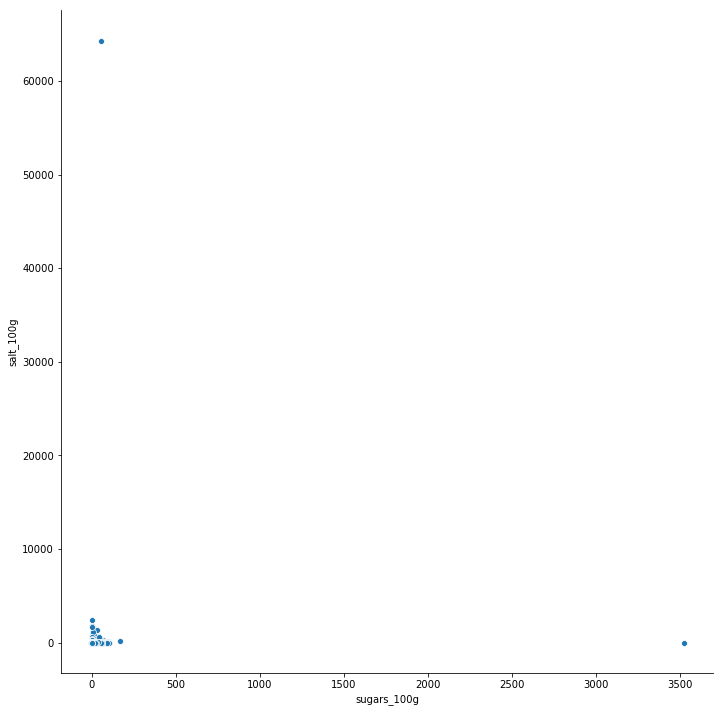

In [72]:
sns.pairplot(df.reset_index().set_index('product_name'),x_vars='sugars_100g',y_vars='salt_100g',size=10)